In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
import sweetviz as sv
import math
from pandas_profiling import ProfileReport

In [201]:
mp_MGX = pd.read_csv('~/Desktop/To_prediction/Metaphlan4_all_pheno.csv').rename(columns={'Unnamed: 0' : 'External ID'})
mp_MGX = mp_MGX.set_index('External ID')
mp_MGX = mp_MGX.loc[:,mp_MGX.columns.str.startswith('s__')]
mp_MGX

,s__Phocaeicola_vulgatus,s__Eubacterium_rectale,s__Dialister_invisus,s__Roseburia_faecis,s__Roseburia_inulinivorans,s__Faecalibacterium_prausnitzii,s__Bacteroides_xylanisolvens,s__Firmicutes_bacterium_AF16_15,s__Bacteroides_uniformis,s__Ruminococcus_bromii,...,s__GGB4700_SGB6506,s__GGB3632_SGB4921,s__GGB4710_SGB6522,s__GGB4706_SGB6513,s__GGB3643_SGB4948,s__Sanguibacteroides_SGB1777,s__GGB3632_SGB4920,s__Lachnospiraceae_bacterium_NSJ_46,s__Prevotella_sp_DNF00663,s__Collinsella_SGB14747
External ID,,,,,,,,,,,,,,,,,,,,,
PSM7J14T,15.31536,13.94141,10.69556,7.68462,5.73822,5.27124,2.86237,2.64634,2.43370,2.42332,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
CSM79HOL,24.17052,2.73550,10.69556,3.82165,0.34793,9.61561,2.86237,0.32024,15.73039,2.42332,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
CSM67U9D,13.61937,6.21772,10.69556,3.12140,0.33679,14.35164,0.00784,0.51562,14.54934,2.72283,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
MSM6J2MF,0.00661,25.14628,0.45208,5.96816,1.09833,9.39927,0.00784,0.51562,0.00027,2.72283,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
HSM7J4N4,12.53121,0.07016,0.45208,5.96816,1.09833,5.16674,1.39312,0.44382,3.51972,2.72283,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MSMA26BL,7.85503,3.04011,0.17321,0.33367,0.34869,14.87397,2.93778,0.03789,5.05285,0.64399,...,0.05404,0.05911,0.18696,0.23143,0.01579,0.00464,0.04352,0.01596,0.02668,0.01905
MSM79H9A,1.31148,0.39673,0.17321,0.01473,0.34869,0.19539,2.93778,0.00492,10.47847,8.31700,...,0.05404,0.05911,0.18696,0.23143,0.01579,0.00464,0.04352,0.01596,0.02668,0.01905
HSM7J4KK,14.84775,4.11094,0.17321,0.01473,0.34869,2.96621,0.26412,0.16380,1.18948,8.31700,...,0.05404,0.05911,0.18696,0.23143,0.01579,0.00464,0.04352,0.01596,0.02668,0.01905


In [202]:
metadata = pd.read_csv("~/Desktop/hmp2_metadata.csv")
fecalcal_info = metadata.loc[metadata.data_type == "metagenomics", ["External ID", "Participant ID", "diagnosis", "visit_num", "fecalcal", "fecalcal_ng_ml"]]
fecalcal_info = fecalcal_info[~fecalcal_info["External ID"].str.contains("_P")]
fecalcal_info = fecalcal_info[~fecalcal_info["External ID"].str.contains("_TR")]
# print( fecalcal_info.drop(fecalcal_info[fecalcal_info["External ID"].str.contains('_P')]))
fc1 = [not math.isnan(x) for x in fecalcal_info.fecalcal]
fc2 = [not math.isnan(x) for x in fecalcal_info.fecalcal_ng_ml]
fc = [fc1[i] or fc2[i] for i in range(len(fc1))]
fecalcal_info = fecalcal_info.loc[fc, :]
fc1 = [not math.isnan(x) for x in fecalcal_info.fecalcal]
fc2 = [not math.isnan(x) for x in fecalcal_info.fecalcal_ng_ml]
fecalcal_info.fecalcal = fecalcal_info.fecalcal.fillna(fecalcal_info['fecalcal_ng_ml'])
fecalcal_info.drop(["fecalcal_ng_ml"], inplace=True, axis=1)
diagnosis = fecalcal_info.loc[:, ["Participant ID", "diagnosis"]].drop_duplicates()
diagnosis["External ID"] = fecalcal_info["External ID"]
# diagnosis.set_index(["Participant ID"], inplace=True)
diagnosis
fecalcal_info

/var/folders/qz/fy7nnm954f76spkqc86w7g_c0000gn/T/ipykernel_3391/3315607127.py:1: DtypeWarning: Columns (12,13,14,40,46,55,65,66,67,68,177,294,298,299,300,301,304,305,306,307,308,309,310,318,320,328,330,346,348,350,352,354,359,361,363,366,373,377,381,383,418,419,432,433,434,435,436,438,439,440,441,442,444,445,446,447,448,450,451,452,453,454) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("~/Desktop/hmp2_metadata.csv")


,External ID,Participant ID,diagnosis,visit_num,fecalcal
1080,CSM67UA2,C3001,CD,20,23.20350
1083,CSM79HGP,C3001,CD,26,37.17836
1092,CSM5MCVN,C3002,CD,13,15.97901
1094,CSM67UBH,C3002,CD,19,14.51068
1095,CSM67UBN,C3002,CD,22,16.32450
...,...,...,...,...,...
2676,PSMA264Q,P6035,UC,6,63.81772
2678,PSMA264U,P6035,UC,8,17.44622
2680,PSMA267J,P6035,UC,12,15.50000
2681,PSMA267P,P6035,UC,15,14.57958


In [203]:
max = fecalcal_info.groupby("Participant ID").max()
min = fecalcal_info.groupby("Participant ID").min()
MM_fecalcal = pd.concat([max,min], axis=0).sort_index()
MM_fecalcal = MM_fecalcal.drop(columns=["visit_num"])

In [204]:
MM_fecalcal.loc[MM_fecalcal["fecalcal"] < 150 , 'stage'] = 'remission'
# MM_fecalcal.loc[MM_fecalcal["fecalcal"].between(50,150) , 'stage'] = 'middle'
MM_fecalcal.loc[MM_fecalcal["fecalcal"] >= 150 , 'stage'] = 'flare'


MM_fecalcal.set_index("External ID",inplace=True)
MM_fecalcal = MM_fecalcal.loc[MM_fecalcal["diagnosis"] != "nonIBD"]
MM_fecalcal

,diagnosis,fecalcal,stage
External ID,,,
CSM79HGP,CD,37.17836,remission
CSM67UA2,CD,23.20350,remission
CSM5MCVN,CD,14.51068,remission
CSM67UBN,CD,16.32450,remission
CSM79HLM,UC,14.30000,remission
...,...,...,...
PSMA263W,CD,289.22620,flare
PSM7J12V,UC,15.90414,remission
PSM7J1BX,UC,21.31494,remission


In [263]:
main_RF = pd.merge(mp_MGX, MM_fecalcal, left_index=True, right_index=True)
main_RF

,s__Phocaeicola_vulgatus,s__Eubacterium_rectale,s__Dialister_invisus,s__Roseburia_faecis,s__Roseburia_inulinivorans,s__Faecalibacterium_prausnitzii,s__Bacteroides_xylanisolvens,s__Firmicutes_bacterium_AF16_15,s__Bacteroides_uniformis,s__Ruminococcus_bromii,...,s__GGB4706_SGB6513,s__GGB3643_SGB4948,s__Sanguibacteroides_SGB1777,s__GGB3632_SGB4920,s__Lachnospiraceae_bacterium_NSJ_46,s__Prevotella_sp_DNF00663,s__Collinsella_SGB14747,diagnosis,fecalcal,stage
External ID,,,,,,,,,,,,,,,,,,,,,
CSM5MCVN,51.31297,0.95498,1.54371,0.04588,0.18414,1.99150,7.95270,0.01466,18.67487,0.34879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD,14.510680,remission
CSM5MCWE,0.17618,0.00034,2.11566,0.77226,1.37207,0.00574,2.53496,0.24880,0.00994,0.48851,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD,16.149950,remission
CSM5MCX3,32.93516,3.94442,0.62092,0.41659,1.16966,6.48479,0.13339,1.12532,2.54236,0.63406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UC,12.698170,remission
CSM5MCXL,32.29455,3.46622,2.09791,9.10884,0.71850,2.63304,0.00904,0.55343,12.83634,0.12034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UC,14.824100,remission
CSM5MCY8,40.22876,0.56787,0.15291,0.04742,0.30914,2.20589,0.01291,0.15447,8.33000,0.22200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UC,212.600000,flare
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PSM7J1CU,0.01314,1.82220,0.21039,11.49237,0.19576,17.15622,13.25230,0.26376,4.43274,0.09877,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD,276.832168,flare
PSMA263W,7.35833,0.09147,1.33126,0.37672,0.13550,3.55648,0.07945,0.19941,6.68211,0.42610,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CD,289.226200,flare
PSMA264O,8.33563,0.19689,0.79575,2.98076,0.95547,13.34191,0.12200,0.05702,1.27741,1.09056,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UC,14.579580,remission


In [206]:
main_RF = main_RF.loc[:,main_RF.columns != "diagnosis"]
# main_RF = main_RF.loc[:,main_RF.columns != "fecalcal"]

MTX_X = main_RF.iloc[:,1:1097]
MTX_y = main_RF.iloc[:,-1]

#fill NA's
MTX_X.fillna(MTX_X.median(), inplace=True)
MTX_X = StandardScaler().fit_transform(MTX_X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(MTX_X, MTX_y, test_size=0.30, random_state=42)


Best Model:
RandomForestClassifier(max_features=None, n_estimators=5, random_state=42)


<AxesSubplot:>

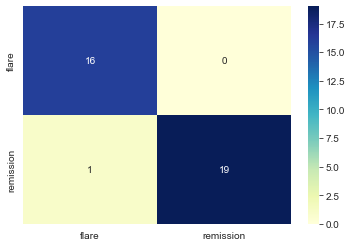

In [261]:
n_estimators_RF = [5, 10, 25, 50, 100]
max_features_RF = [2,4,8,16,32,None]
parameters_RF = {'n_estimators': n_estimators_RF,
                'max_features': max_features_RF}

RF_model = RandomForestClassifier(max_depth=None,
                                  min_samples_split=2, random_state=42)

RF_clf = GridSearchCV(RF_model, parameters_RF, cv=5, scoring= 'accuracy') #completeness_score')

RF_clf.fit(X_train, y_train)

print("Best Model:")
RF_model = RF_clf.best_estimator_
print(RF_model)

RF_predictions = RF_model.predict(X_test)

# creating a confusion matrix
labels = np.unique(y_test)
cm_RF = confusion_matrix(y_test, RF_predictions,labels=labels)
cm_RF = pd.DataFrame(cm_RF, index=labels, columns=labels)
sns.heatmap(cm_RF, cmap="YlGnBu", annot=True)

In [252]:
from sklearn import metrics
print(f'Accuracy {round(metrics.accuracy_score(y_test, RF_predictions)*100,2)}%')

Accuracy 97.22%
